In [59]:
!pip install torchviz -q
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

# Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


from tqdm.notebook import tqdm

/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2021/train.csv
/kaggle/input/tabular-playground-series-jun-2021/test.csv


In [29]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/train.csv", index_col = 'id')
test = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/test.csv", index_col = 'id')
TARGET = 'target'
RANDOM_STATE = 2021

In [30]:
train = train[~train.drop('target', axis = 1).duplicated()]
train.shape

(199776, 76)

In [31]:
X = pd.DataFrame(train.drop("target", axis = 1))

lencoder = LabelEncoder()
y = pd.DataFrame(lencoder.fit_transform(train['target']), columns=['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

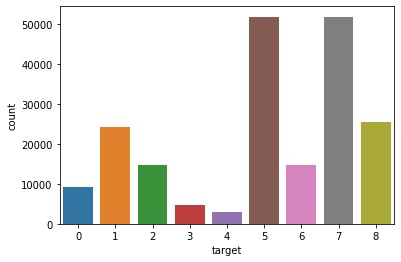

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state= RANDOM_STATE)

sns.countplot(x = TARGET, data= y)

In [33]:
# NN likes numbers from 0-1 .... so we scale our dataset 
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [34]:
X_train, y_train = np.array(X_train, dtype= np.float32), y_train['target'].values 
X_valid, y_valid = np.array(X_valid, dtype= np.float32), y_valid['target'].values

In [35]:
display(X_train)

array([[0.08196721, 0.        , 0.171875  , ..., 0.01639344, 0.02307692,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03278688, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01538462,
        0.        ]], dtype=float32)

In [36]:
display(X_train)
display(X_valid)

array([[0.08196721, 0.        , 0.171875  , ..., 0.01639344, 0.02307692,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03278688, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01538462,
        0.        ]], dtype=float32)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07843138, 0.015625  , ..., 0.        , 0.06153846,
        0.05769231],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00769231,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03278688, 0.        , 0.015625  , ..., 0.04918033, 0.        ,
        0.        ]], dtype=float32)

In [37]:
# Here we will define all params for rest of notebook

BATCH_SIZE = 64
NUM_FEATURES = len(train.columns)-1
NUM_CLASSES = 9
NUM_EPOCHS = 100

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
# Here we will define all params for rest of notebook

class TPS05Dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# As you can see we define torch arrays - then we will put them into device
train_dataset = TPS05Dataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
valid_dataset = TPS05Dataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())

In [40]:
# Data loaders 
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)

In [41]:
dataiter = iter(train_loader)
train_features, train_labels = dataiter.next()
print('Batch #1')
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("First row from batch #1")
print(train_features[1])

# take next batch (another way)
train_features, train_labels = dataiter.next()
print('\nBatch #2')
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("First row from batch #2")
print(train_features[1])

Batch #1
Feature batch shape: torch.Size([64, 75])
Labels batch shape: torch.Size([64])
First row from batch #1
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0526, 0.0000, 0.0233, 0.0000, 0.0263,
        0.0000, 0.0000, 0.0000, 0.0811, 0.0000, 0.0000, 0.0000, 0.0370, 0.0000,
        0.0909, 0.0532, 0.0333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0833,
        0.0119, 0.0095, 0.0833, 0.0455, 0.0000, 0.0000, 0.0244, 0.0278, 0.0000,
        0.0000, 0.0294, 0.0000, 0.0612, 0.0370, 0.0548, 0.0189, 0.0794, 0.0370,
        0.1000, 0.0085, 0.0000, 0.0000, 0.0000, 0.0179, 0.0137, 0.0000, 0.0000,
        0.0096, 0.0921, 0.0870, 0.0000, 0.0000, 0.0123, 0.0173, 0.0000, 0.0000,
        0.0375, 0.0000, 0.0000, 0.0000, 0.0127, 0.0000, 0.0000, 0.0597, 0.0000,
        0.0000, 0.0000, 0.0000])

Batch #2
Feature batch shape: torch.Size([64, 75])
Labels batch shape: torch.Size([64])
First row from batch #2
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000

In [42]:
class TPS05ClassificationModule(nn.Module):
    def __init__(self, num_feature, num_class):
        super(TPS05ClassificationModule, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, num_class)
        
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.2)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = self.layer_1(x)
       #x = self.batchnorm_1(x)
        x = F.relu(x)   # Second one using torch.nn.functional
        x = self.dropout_1(x)
        
        x = self.layer_2(x)
       #x = self.batchnorm_2(x)
        x = self.softmax(x)
        x = self.dropout_2(x)
        
        x = self.layer_3(x)
        #x = self.batchnorm_3(x)
        x = self.softmax(x)
        x = self.dropout_2(x)
        
        x = self.layer_out(x)
        return x
    

In [43]:
modelMod = TPS05ClassificationModule(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
# Then pushi it to device (CPU/GPU)

# model.eval() is switch off for some specific layers/parts of the model (Dropouts Layers, BatchNorm Layers etc.) 
modelMod.eval()

# Whenever you want you can print model 
print(modelMod)

TPS05ClassificationModule(
  (layer_1): Linear(in_features=75, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=9, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
model = modelMod

In [46]:

Learning_Rate = 0.001
optimizer = optim.Adam(model.parameters(),lr=Learning_Rate)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

In [47]:
class EarlyStoppingCallback:   
    def __init__(self, min_delta = 0.0000001, patience = 2):
        
        self.min_delta = min_delta
        self.patience = patience
        self.best_epoch_score = 0
        
        self.attempt = 0
        self.best_score = None
        self.stop_training = False
        
        
    def __call__(self, validation_loss):

        self.epoch_score = validation_loss

        if self.best_epoch_score == 0:
            self.best_epoch_score = self.epoch_score
        elif self.epoch_score > self.best_epoch_score - self.min_delta:
            self.attempt += 1
            print(f'Message from callback (Early Stopping) counter: {self.attempt}/{self.patience}')
            if self.attempt >= self.patience:
                self.stop_training = True
        else:
            self.best_epoch_score = self.epoch_score
            self.attempt = 0

In [48]:
accuracy_stat = {'train': [],"validation": []}
loss_stat = {'train': [], "validation": [] }

def acc_calc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [49]:
def train_nn():
    for progress in tqdm(range(1, NUM_EPOCHS+1)):

        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()

        # We loop over training dataset using batches (we use DataLoader to load data with batches)
        for X_train_batch, y_train_batch in train_loader:
            

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass ->>>>
            y_train_pred = model(X_train_batch)

            # Find Loss and backpropagation of gradients
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = acc_calc(y_train_pred, y_train_batch)

            # backward <------    
            train_loss.backward()

            # Update the parameters (weights and biases)
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        #  Then we validate our model - concept is the same
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in valid_loader:
               

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = acc_calc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        # end of validation loop
        early_stopping_callback(val_epoch_loss/len(valid_loader))
        if early_stopping_callback.stop_training:
            print(f'Training stopped -> Early Stopping Callback : validation_loss: {val_epoch_loss/len(valid_loader)}')
            break

        loss_stat['train'].append(train_epoch_loss/len(train_loader))
        loss_stat['validation'].append(val_epoch_loss/len(valid_loader))
        accuracy_stat['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stat['validation'].append(val_epoch_acc/len(valid_loader))                           
        
        
        # 2021.05.17 
        # This is a part of NN optimization
        clr = optimizer.param_groups[0]['lr']        
        scheduler.step(val_epoch_acc/len(valid_loader))

        print(f'Epoch { progress + 0:03}: Loss: [Train: {train_epoch_loss/len(train_loader):.5f} | Validation: {val_epoch_loss/len(valid_loader):.5f} ] Accuracy: [Train: {train_epoch_acc/len(train_loader):.3f} | Validation: {val_epoch_acc/len(valid_loader):.3f}] LR: {clr}')

In [50]:
early_stopping_callback = EarlyStoppingCallback(0.001, 5)

train_nn()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: Loss: [Train: 1.89353 | Validation: 1.83283 ] Accuracy: [Train: 27.240 | Validation: 29.029] LR: 0.001
Epoch 002: Loss: [Train: 1.83511 | Validation: 1.82115 ] Accuracy: [Train: 29.028 | Validation: 29.402] LR: 0.001
Epoch 003: Loss: [Train: 1.82668 | Validation: 1.81589 ] Accuracy: [Train: 30.160 | Validation: 31.339] LR: 0.001
Epoch 004: Loss: [Train: 1.81678 | Validation: 1.79975 ] Accuracy: [Train: 32.368 | Validation: 34.510] LR: 0.001
Epoch 005: Loss: [Train: 1.80556 | Validation: 1.79056 ] Accuracy: [Train: 33.338 | Validation: 34.851] LR: 0.001
Epoch 006: Loss: [Train: 1.79976 | Validation: 1.78806 ] Accuracy: [Train: 33.550 | Validation: 34.886] LR: 0.0001
Message from callback (Early Stopping) counter: 1/5
Epoch 007: Loss: [Train: 1.79822 | Validation: 1.78719 ] Accuracy: [Train: 33.732 | Validation: 34.888] LR: 0.0001
Epoch 008: Loss: [Train: 1.79797 | Validation: 1.78656 ] Accuracy: [Train: 33.632 | Validation: 34.958] LR: 0.0001
Message from callback (Early Stop

In [51]:
df_train_va = pd.DataFrame.from_dict(accuracy_stat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
df_train_vl = pd.DataFrame.from_dict(loss_stat).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

Text(0.5, 1.0, 'Train - Validation Loss/Epoch')

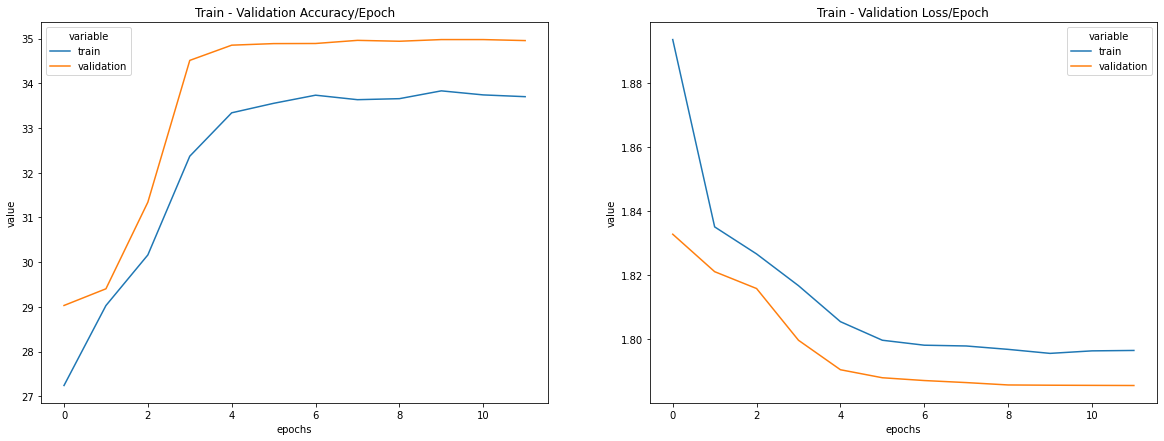

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data = df_train_va, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train - Validation Accuracy/Epoch')
sns.lineplot(data = df_train_vl, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train - Validation Loss/Epoch')

In [53]:
tensor_preds = model(torch.from_numpy(scaler.transform(test)).float())
tensor_preds[0]

tensor([-0.5253,  1.3552,  0.5681, -1.1689, -1.8857,  0.1198, -0.8076,  0.0249,
         0.4865], grad_fn=<SelectBackward>)

In [54]:
nn_preds = torch.nn.functional.softmax(tensor_preds, dim=1).detach().numpy() 
nn_preds[0]

array([0.05414682, 0.35505256, 0.16160467, 0.02845076, 0.01389182,
       0.10321679, 0.04083069, 0.09386676, 0.14893913], dtype=float32)

In [60]:
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv")
predictions_df = pd.DataFrame(nn_preds, columns = ["Class_1", "Class_2", "Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"])
predictions_df['id'] = sub['id']

In [61]:
predictions_df.head(5)

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,id
0,0.054147,0.355053,0.161605,0.028451,0.013892,0.103217,0.040831,0.093867,0.148939,200000
1,0.045893,0.083760,0.060681,0.023475,0.016016,0.272777,0.080831,0.287060,0.129506,200001
2,0.029942,0.039342,0.029493,0.013779,0.010129,0.515680,0.056322,0.228883,0.076429,200002
3,0.044032,0.068996,0.052842,0.022521,0.015931,0.270974,0.085383,0.315807,0.123513,200003
4,0.048070,0.092916,0.066905,0.025012,0.016849,0.241142,0.083447,0.287768,0.137892,200004


In [62]:
predictions_df.drop("id", axis=1).describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Class_1,100000.000000,0.045740,0.007787,0.025641,0.041372,0.045453,0.053209,0.056215
Class_2,100000.000000,0.123167,0.098460,0.030910,0.052992,0.077325,0.158921,0.394177
Class_3,100000.000000,0.074959,0.041378,0.023380,0.043273,0.057579,0.099912,0.169267
Class_4,100000.000000,0.023631,0.004806,0.011457,0.021188,0.023403,0.028058,0.030345
Class_5,100000.000000,0.015337,0.002203,0.008582,0.014521,0.015902,0.016871,0.018194
Class_6,100000.000000,0.255958,0.111926,0.088649,0.187454,0.250283,0.279559,0.584999
Class_7,100000.000000,0.073906,0.016675,0.035557,0.063718,0.077072,0.088747,0.093171
Class_8,100000.000000,0.258350,0.082705,0.077559,0.210155,0.264478,0.332742,0.365018
Class_9,100000.000000,0.128952,0.025956,0.063448,0.114250,0.128369,0.151516,0.169476


In [63]:
predictions_df.to_csv("NN_Pytorch_submission.csv", index = False)